# Simple Moving Average SMA

The design of this strategy is inspired by the lecture 2 of Algorithmic Trading, original source obtained from  [Algorithmic Trading Society Lectures Imperial College London](https://github.com/algotradingsoc/Lectures2022/blob/main/AlgoTradeSocLectures.ipynb)


To use in combination with AirBorne one first need to add Direct Search Manually and then AirBorne
```julia
add https://github.com/ImperialCollegeLondon/DirectSearch.jl
add "https://github.com/JuDO-dev/AirBorne.jl#dev"
add "https://github.com/JuDO-dev/AirBorne.jl#sma"
```

Once a module is added for the first time in order to refresh or switch the branch the command changes to:

```julia
add AirBorne#sma
```

# Julia Features Test

## Draft
The first step is to simply write the trading functions as a draft outside any module, test them and evaluate if the functions behave as expected. Since this is the first strategy for **production** metrics are also going to be put forward.

Therefore by the end of this Notebook code for several submodules is going to be developed

**Portfolio Calculations**

A question to solve is how the computation coming from the portfolio are stored? A simple answer would be inside the *extras* key of the **context** variable. Not all strategies may make use of portfolio calculations (like total value of portfolio), therefore an optional nature of its storage seems to be desirable.

**Metrics**
1. Returns: Given a series of stockprice calculate the returns
3. Variance & Covariance: Of Portfolio and individual assets.
2. Sharpe: 

### StaticMarket.jl

In [21]:
# StaticMarket.jl
# ModulePath: AirBorne.Markets.StaticMarket
# add DotMaps
# New order execution method.

using AirBorne:Money, Wallet, Portfolio
using AirBorne.Structures: ContextTypeB, TimeEvent
using AirBorne.Markets.StaticMarket:Order
using DataFrames: DataFrame
using DotMaps: DotMap

function addMoneyToAccount!(account::Wallet, journal_entry)
    # journal_entry["amount"] is Money
    account += journal_entry["amount"]*-1 # Does not update original!!!!!
    @info account
    return nothing
end

function addSecurityToPortfolio!(portfolio::Portfolio, journal_entry::Union{DotMap,Dict}) # Multiple-dispatch of method in case of portfolio being a vector.
    asset_symbol = get(
        journal_entry,
        "assetID",
        Symbol(keyJE(journal_entry)),
    )
    portfolio += Security{asset_symbol}(journal_entry["shares"])
    return nothing
end

function executeOrder_CB(
    context::ContextTypeB, order::Order, cur_data::DataFrame; priceModel::Function=refPrice
)    
    success = true
    if order.specs.type == "MarketOrder"
        price = priceModel(cur_data, order.specs.ticker)
        shares = order.specs.shares
        currency = get_symbol(price)
        transaction_amount = price.value * shares
        shares = order.specs.shares
        success=true
        if  context.accounts[currency] < transaction_amount
            success=false
            transaction_amount = context.accounts[currency]
            shares = transaction_amount / price.value
        end
        journal_entry = Dict(
            "exchangeName" => order.market,
            "ticker" => order.specs.ticker,
            "shares" => shares,
            "price" => price,
            "amount" => Money(transaction_amount,currency),
            "date" => context.current_event.date,
        )
    elseif order.specs.type == "LimitOrder"
        throw("LimitOrder has not yet been implemented, please use MarketOrder")
    end
    return journal_entry, success
    
end


1-element Vector{Any}:
 Order("NMS", DotMap(Dict{Symbol, Any}(:type => "MarketOrder", :account => Wallet object containing:
  100000.00USD
, :ticker => "AAPL", :shares => 98445.15282276318)))

In [ ]:
########################################################################
using Dates: now,DateTime 
using AirBorne:Money,get_symbol
using AirBorne.Utils: get_latest
using AirBorne.Structures: TimeEvent
using AirBorne.ETL.Cache: load_bundle
using AirBorne.Markets.StaticMarket:available_data, refPrice, place_order!, execute_orders!
using DotMaps: DotMap
using Dates: DateTime

# Load data
data = load_bundle("SMA_1") # Tune the data
data[!,"currency"]=Symbol.(data.currency)
data[!,"market_price"]=data.open .* Money.(data.currency)
data[!,"assetID"]=Symbol.(data.symbol)

# Set Context
event = TimeEvent(DateTime("2020-03-01T10:30:00"),"NewEvent")
context = ContextTypeB(event)
context.accounts+= 10^5 * Money(:USD) # Add $100,000 to your account

# Generate Order
order_specs = DotMap(Dict()) # Order structure remains the same
order_specs.ticker = "AAPL"
order_specs.shares = 10^5
order_specs.type = "MarketOrder"
order_specs.account = context.accounts
order = Order("NMS", order_specs)

# Place Order
place_order!(context,order) 

# cur_data = get_latest(available_data(context, data), [:exchangeName, :symbol], :date)
# price = refPrice(cur_data,order.specs.ticker;col=:market_price)
# currency = get_symbol(price)
# transaction_amount = price.value * order.specs.shares
# shares = order.specs.shares
# success=true
# if  context.accounts[currency] < transaction_amount
#     success=false
#     transaction_amount = context.accounts[currency]
#     shares = transaction_amount / price.value
# end
    
# # data[!,"market_price"]=Money.(Symbol.(data.currency)).*data.open
# # data[!,"value"] =USD .* data.close
# # cur_data = get_latest(available_data(context, data), [:exchangeName, :symbol], :date)
# # data
# @info shares
# @info transaction_amount
            
# Custom Pricing Mechanism
priceModel(cur_data,ticker)=refPrice(cur_data,ticker;col=:market_price)
# Custom Single Order Execution
eO(ctx,ord,cd)= executeOrder_CB(ctx,ord,cd; priceModel=priceModel)

execute_orders!(context,data;executeOrder=eO)

### AssetValuation.jl

In [179]:
# AssetValuation.jl
# ModulePath: Airborne.ETL.AssetValuation

using DataFrames: DataFrame
using Dates: DateTime
using Statistics: cov

""" 
    assetValue(data::DataFrame;method::Symbol=:last_open)

    Provides a method to calculate the value of an asset given some data.
"""
function valuePortfolio(portfolio::Dict,stockValues::Dict)
    value=0
    for assetID=keys(portfolio)
        value+= portfolio[assetID] * stockValues[assetID]
    end
    return value
end

"""
    stockValuation(data::DataFrame ;col::Symbol=:close,assetCol::Symbol=:assetID)

    Provides the value of individual tickers (share of an equity asset) at a certain 
    point in time given a OHLCV dataframe.
"""
function stockValuation(data::DataFrame ;col::Symbol=:close,assetCol::Symbol=:assetID)
    # Produce for each date and assetID (assetCol) a 3 column table with date, assetID and Value
    agg = combine(groupby(data,[:date, assetCol]),col => mean => :stockValue)
    # Generate 1 column per assetID containing its value and 1 row per date. ust stands for "unstacked"
    ust = unstack(agg,assetCol,:stockValue) 
    # Create an additional column summarizing the date values in a dictionary
    ust[!,"stockValue"] = [ Dict([ t=> x[t] for t in names(x) if t!="date" ]) for x in eachrow(ust)]
    return ust
end

"""
    Calculates the covariance matrix given a Asset Value DataFrame or an Asset Return DataFrame.
"""
function covariance(assetValuesdf::DataFrame)
    cov(Matrix(sVdf[:, filter(x -> x ∉["date","stockValue","stockReturns"], names(assetValuesdf))]))
end


"""
    Calculates the returns of each ticker in the Asset Value DataFrame. By default as the relative percent with respect to the previous element,
    the return of the first element is set to 0 as the starting point.
"""
function returns(assetValuesdf::DataFrame) 
    out = deepcopy(assetValuesdf)
    for x=filter(x -> x ∉["date","stockValue","stockReturns"], names(assetValuesdf))
        out[!,x] = returns(out[!,x])
    end
    return out
end

"""
    Calculates the returns as relative percent with respect to the previous element. The return of the first element is set to 0 as the starting point.
"""
function returns(array::Vector)
    out = Array{Union{Float64,Nothing}}(undef,length(array)) # Preallocate memory
    out[1]=0.0 # First return is always 0 (starting value)
    for i = 2:length(array)
       out[i] =  (array[i]-array[i-1])/array[i-1]
    end
    ust[!,"stockReturns"] = [ Dict([ t=> x[t] for t in names(x) if t!="date" ]) for x in eachrow(ust)]
    return out
end


function sharpe(avgReturn::Vector,variance::Vector;riskFreeRate::Real=0.0)
    out = Array{Union{Float64,Nothing}}(undef,length(avgReturn)) # Preallocate memory
    for i = 1:length(avgReturn)
        if (variance[i] ∉ [0, nothing] && !isnan(variance[i]) && avgReturn[i] ∉ [nothing] && !isnan(avgReturn[i])  )
           out[i] =  (avgReturn[i]-riskFreeRate)/variance[i]
        end
    end
    return out
end

function sharpe(returns::Vector;riskFreeRate::Real=0.0,windowSize::Union{Int,Nothing}=nothing, startFrom::Int=1)
    avgReturn = movingAverage(returns; windowSize=windowSize, startFrom=startFrom)
    variance = makeRunning(returns,std; windowSize=windowSize, startFrom=startFrom)
    return sharpe(avgReturn,variance;riskFreeRate=riskFreeRate)
end




sharpe (generic function with 2 methods)

### Utils.jl

In [14]:
using DataFrames:DataFrame, missing
# function lagFill(df::DataFrame, col::Symbol; respect_nothing::Bool=false)
#     filledArray = df[!, col]
#     for i in 2:length(filledArray)
#         if (filledArray[i] === missing) || (!(respect_nothing) && filledArray[i] === nothing)
#             filledArray[i] = filledArray[i - 1]
#         end
#     end
#     return filledArray
# end
function lagFill(inV::Vector; fill::Vector=[missing,nothing])
    out = inV
    trigger_funs=[]
    if any(ismissing.(fill))
        deleteat!(fill, findall(x->ismissing(x),fill))
        push!(trigger_funs,ismissing)
    end
    if any(isnothing.(fill))
        deleteat!(fill, findall(x->isnothing(x),fill))
        push!(trigger_funs,isnothing)
    end

    
    for i in 2:length(out)
        if any([f(out[i] ) for f in trigger_funs]) ||  (out[i]  ∈ fill)
            out[i] = out[i - 1]
        end
    end
    return out
end
# function lagFill(df::DataFrame, col::Symbol; fill::Vector=[missing,nothing])
#     filledArray = df[!, col]
#     trigger_funs=[]
#     if any(ismissing.(fill))
#         deleteat!(fill, findall(x->ismissing(x),fill))
#         push!(trigger_funs,ismissing)
#     end
#     if any(isnothing.(fill))
#         deleteat!(fill, findall(x->isnothing(x),fill))
#         push!(trigger_funs,isnothing)
#     end

    
#     for i in 2:length(filledArray)
#         x = filledArray[i] 
#         if any([f(x) for f in trigger_funs]) ||  (x ∈ fill)
#             filledArray[i] = filledArray[i - 1]
#         end
#     end
#     return filledArray
# end


"""
    Given a function (mean, variance, sharpe,...) from an 1-D array to a single element
    It creates an array with same size of original with the function applied from the 
    beggining of the array to the index of the output. 

    !!! Tip "Performance"
        This function is not meant to be highly performant. If a function is used function is
        advised to have a specialized function to calculate its running counterpart.

    # Optional Arguments
    - `windowSize::Union{Int,Nothing}`: If its desired to truncate the number of past elements to be considered, this field can be set to the maximum number of past elements to take into account. This can be used for Moving Averages for example. 
    - `ignoreFirst::Int`: Indicates for how many elements the operation should not be applied. In those elements "nothing" will be placed instead.
"""
function makeRunning(array::Vector, fun::Function; windowSize::Union{Int64,Nothing}=nothing, startFrom::Int=1)
    out = Array{Union{Float64,Nothing}}(undef,length(array)) # Preallocate memory
    start(i) = windowSize === nothing ? startFrom : max(i-windowSize+1,startFrom)
    for i = startFrom:length(array)
        # @info "$(start(i)) - $i :" array[start(i):i] # Uncomment to see input of function.
       out[i] =  fun(array[start(i):i])
    end
    return out
end

"""
    More efficient implementation of a moving average (mean running).
"""
function movingAverage(array::Vector; windowSize::Int=1, startFrom::Int=1)
    out = Array{Union{Float64,Nothing}}(undef,length(array)) # Preallocate memory
    start(i) =  max(i-windowSize,1)
    factor(i) = min(windowSize,i+1-startFrom)
    sum_value = 0
    for i = startFrom:length(array)
        # @info "$(start(i)) - $i :" array[start(i):i] # Uncomment to see input of function.
       sum_value+= array[i]
       sum_value-= i+1-startFrom > windowSize ? array[start(i)] : 0
       out[i] =  sum_value / factor(i)
    end
    return out
end

movingAverage

### SMA.jl

## Test

### Add Data

In [2]:
# If data needs to be generated
using AirBorne.ETL.YFinance: get_interday_data
using AirBorne.ETL.Cache: load_bundle, store_bundle
using Dates: DateTime,datetime2unix
bundle_id="SMA_1"
cache_dir = joinpath(@__DIR__, "assets", "cache")
# To generate this data use:
from = DateTime("2017-01-01"); to = DateTime("2022-01-01")
u_from = string(round(Int, datetime2unix(from))); u_to = string(round(Int, datetime2unix(to)))
data = get_interday_data(["AAPL","GOOG"], u_from, u_to)

# For some reason  the column type is still "Any". Minor bug but annoying. 
data[!,:close]=float.(data[!,:close])
data[!,:high]=float.(data[!,:high])
data[!,:low]=float.(data[!,:low])
data[!,:open]=float.(data[!,:open])
data[!,:unix]=Int.(data[!,:unix])
data[!,:volume]=Int.(data[!,:volume])

data[!,"assetID"] = data.exchangeName .* "/" .* data.symbol
# show(data)
store_bundle(data; bundle_id=bundle_id, archive=true, cache_dir=cache_dir) 


[ Info: Storing /root/project/notebooks/assets/cache/SMA_1/2023_07_15_14_41_47_42.parq.snappy


✏ Parquet2.FileWriter{IOStream}(/root/project/notebooks/assets/cache/SMA_1/2023_07_15_14_41_47_42.parq.snappy)

In [4]:
# If you want to load a previously cached data.
using AirBorne.ETL.Cache: load_bundle
bundle_id="SMA_1"
data = load_bundle(bundle_id)
@info "Done"
# The code below will indicate if the data complies with a known schema
# using AirBorne.ETL.Transform: getSchema, schemas
# using Tables: schema
# @info "Data schema: $(getSchema(schema(data)))"
# data

[ Info: Done


### Run Simulation

In [5]:
using AirBorne.Engines.DEDS: run
using AirBorne.Markets.StaticMarket: execute_orders!, expose_data

# my_initialize!(context) = initialize!(context;longHorizon=100, shortHorizon=30, initialCapital=10^4)
my_initialize!(context) = initialize!(context;longHorizon=30, shortHorizon=7,initialCapital=10^4)
my_trading_logic!(context,data) = trading_logic!(context,data)

# Run Simulation
# max_iter = 100
@time context = run(
    data,
    my_initialize!,
    my_trading_logic!,
    execute_orders!,
    expose_data;
    audit=true,
    # max_iter=max_iter,
)
print("Done")


 34.843581 seconds (30.24 M allocations: 1.648 GiB, 3.47% gc time, 33.56% compilation time)
Done

### Post Processing

In [20]:
# portfolio_history[!,"NMS/AAPL"]
portfolio_history

Row,NMS/GOOG,NMS/AAPL
,Union…,Union…
1,0,0
2,0,0
3,100,100
4,100,100
5,100,100
6,100,100
7,0,100
8,0,100
9,0,100


In [39]:
# Post Processing
using Plots: plot
using AirBorne.Markets.StaticMarket: parse_portfolioHistory, parse_accountHistory, execute_orders!
portfolio_history = parse_portfolioHistory(context.audit.portfolioHistory)
replace!(portfolio_history[!,"NMS/AAPL"], nothing=>0)
replace!(portfolio_history[!,"NMS/GOOG"], nothing=>0)
account_history = parse_accountHistory(context.audit.accountHistory)
# df
x = [e.date for e in context.audit.eventHistory]
eventDf= DataFrame( "date"=>x)

@info length(x)
@info size(portfolio_history)
@info size(account_history)
# portfolio_history[!,"date"]=x
# account_history[!,"date"]=x

[ Info: 1795
[ Info: (1795, 2)
[ Info: (1795, 1)


Row,date
,DateTime
1,2017-01-03T10:30:00
2,2017-02-02T10:30:00
3,2017-02-03T10:30:00
4,2017-02-04T10:30:00
5,2017-02-05T10:30:00
6,2017-02-06T10:30:00
7,2017-02-07T10:30:00
8,2017-02-08T10:30:00
9,2017-02-09T10:30:00


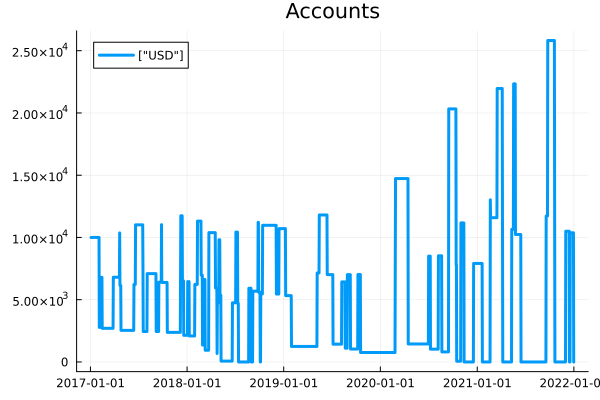

In [24]:

plot(x, [account_history.usd], title="Accounts", label=["USD"], linewidth=3)

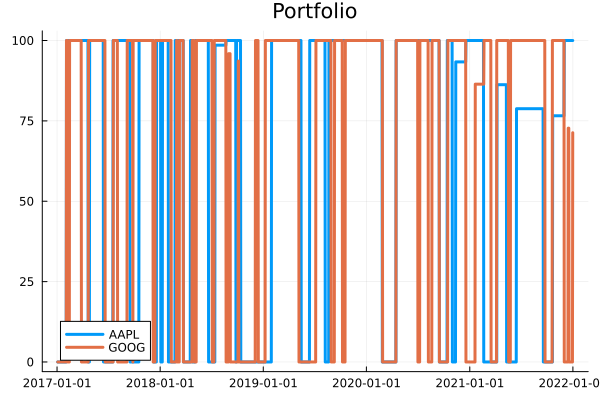

In [25]:

y1=portfolio_history[!,"NMS/AAPL"] 
y2=portfolio_history[!,"NMS/GOOG"]
plot(x, [y1 y2], title="Portfolio", label=["AAPL" "GOOG"], linewidth=3)

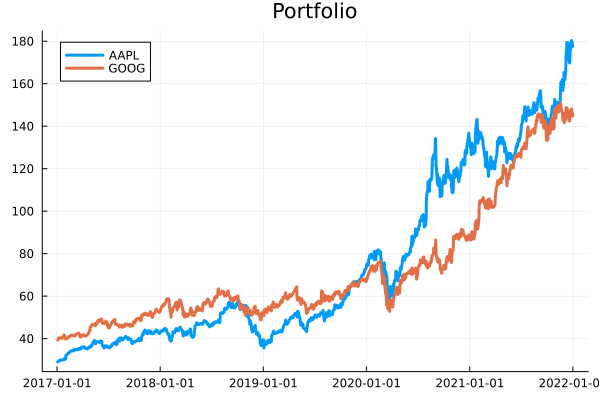

In [31]:
x = data["AAPL".==data[!,:symbol],:].date
y1 = data["AAPL".==data[!,:symbol],:].close
y2 = data["GOOG".==data[!,:symbol],:].close
plot(x, [y1 y2], title="Portfolio", label=["AAPL" "GOOG"], linewidth=3)

In [36]:
@info length(context.extra.ss[1].data.open)
@info context.extra.ss[1].event
@info context.extra.long_horizon
@info context.extra.short_horizon
using MarketTechnicals: sma
using DataFrames: groupby, mean, combine
df = context.extra.ss[1].data
context.extra.ss[1].data.open[:]
shortH= context.extra.short_horizon
longH= context.extra.long_horizon
fun1() = 2

shortSMA(sdf_col) = mean(last(sdf_col, shortH))
longSMA(sdf_col) = mean(last(sdf_col, longH))


function sum2(sdf_col)
    @info sdf
    x = sum(sdf_col)
    @info x
    return x
end

sma_df=combine(groupby(df, ["symbol","exchangeName"]), :close=>shortSMA=>:SMA_S, :close=>longSMA=>:SMA_L,shortSMA_2  )

sma_df[!,:position]= ((sma_df.SMA_S .>= sma_df.SMA_L) .-0.5) .*2
sma_df
for r= eachrow(sma_df)
    

    
end


[ Info: 142
[ Info: TimeEvent(Dates.DateTime("2017-04-13T10:30:00"), "data_transfer")
[ Info: 100
[ Info: 10
[ Info: 0
[ Info: Buy AAPL
[ Info: 0
[ Info: Buy GOOG


In [54]:
using AirBorne.Markets.StaticMarket: execute_orders!
execute_orders!(context,df)

LoadError: MethodError: no method matching execute_orders!(::ContextTypeA, ::DataFrame)
[0mClosest candidates are:
[0m  execute_orders!(::Any, ::Any, [91m::Any[39m, [91m::Any[39m) at ~/.julia/packages/AirBorne/NCCVx/src/Backtest/markets/StaticMarket.jl:85

In [67]:
ust

Row,date,NMS/AAPL,NMS/GOOG,stockValue
,DateTime,Float64?,Float64?,Dict…
1,2017-01-03T10:30:00,29.0375,39.307,"Dict(""NMS/GOOG""=>39.307, ""NMS/AAPL""=>29.0375)"
2,2017-01-04T10:30:00,29.005,39.345,"Dict(""NMS/GOOG""=>39.345, ""NMS/AAPL""=>29.005)"
3,2017-01-05T10:30:00,29.1525,39.701,"Dict(""NMS/GOOG""=>39.701, ""NMS/AAPL""=>29.1525)"
4,2017-01-06T10:30:00,29.4775,40.3075,"Dict(""NMS/GOOG""=>40.3075, ""NMS/AAPL""=>29.4775)"
5,2017-01-09T10:30:00,29.7475,40.3325,"Dict(""NMS/GOOG""=>40.3325, ""NMS/AAPL""=>29.7475)"
6,2017-01-10T10:30:00,29.7775,40.2395,"Dict(""NMS/GOOG""=>40.2395, ""NMS/AAPL""=>29.7775)"
7,2017-01-11T10:30:00,29.9375,40.3955,"Dict(""NMS/GOOG""=>40.3955, ""NMS/AAPL""=>29.9375)"
8,2017-01-12T10:30:00,29.8125,40.318,"Dict(""NMS/GOOG""=>40.318, ""NMS/AAPL""=>29.8125)"
9,2017-01-13T10:30:00,29.76,40.394,"Dict(""NMS/GOOG""=>40.394, ""NMS/AAPL""=>29.76)"


In [17]:
using DataFrames: unstack,  leftjoin, hcat, innerjoin
using Dates: dayofweek
using Statistics: std
"""
    Provides the value of individual tickers at a certain point in time given a OHLCV dataframe.
"""
function stockValuation(long_OHLCV_data::DataFrame ;col::Symbol=:close,assetCol::Symbol=:assetID)
    # Value
    agg = combine(groupby(long_OHLCV_data,[:date, assetCol]),col => mean => :stockValue)
    ust = unstack(agg,assetCol,:stockValue)
    ust[!,"stockValue"] = [ Dict([ t=> x[t] for t in names(x) if t!="date" ]) for x in eachrow(ust)]
    return ust
end

using AirBorne.Structures:ContextTypeA
using DataFrames: DataFrame

"""
    summarizePerformance(data::DataFrame, context::ContextTypeA)

    Given an audit of the portfolio, account, events and OHLCV data it returns a summary of the performance 
    of the portfolio over time.
"""
function summarizePerformance(OHLCV_data::DataFrame, context::ContextTypeA; 
        valuationFun::Function=stockValuation,
        removeWeekend::Bool=false,
        keepDaysWithoutData::Bool=true,
        windowSize::Int=5,
        riskFreeRate::Real=0.0
    )
    summary = DataFrame(
        "date"=>[e.date for e in context.audit.eventHistory],
        "type"=>[e.type for e in context.audit.eventHistory],
      
        "portfolio"=>context.audit.portfolioHistory,
        "account"=>context.audit.accountHistory
        )
    
    joinoperation= keepDaysWithoutData ? leftjoin : innerjoin
    summary = joinoperation(summary, valuationFun(OHLCV_data)[!,["date", "stockValue"]], on = :date)
    
    sort!(summary,:date)
    if removeWeekend
        summary = summary[dayofweek.(summary.date).<6,:]
    end
    summary.stockValue= lagFill(summary.stockValue)
    summary[!,"dollarValue"]=[ valuePortfolio(r.portfolio,r.stockValue) + r.account.usd.balance for r in eachrow(summary) ]
    summary[!,"return"] = returns(summary.dollarValue)
    summary[!,"mean_return"]=makeRunning(summary[!,"return"],mean; windowSize=windowSize)
    summary[!,"std_return"]=makeRunning(summary[!,"return"],std; windowSize=windowSize)
    summary[!,"sharpe"] = sharpe(summary.mean_return,summary.std_return;riskFreeRate=riskFreeRate)
    return summary
end 

# summary=summarizePerformance(data,context;removeWeekend=true)
summary=summarizePerformance(data,context;keepDaysWithoutData=false)
# summary
# summary[!,"mean_return_5"]=makeRunning(summary[!,"return"],mean; windowSize=5,startFrom=2)
# summary[!,"std_return_5"]=makeRunning(summary[!,"return"],std; windowSize=5,startFrom=2)

# makeRunning(summary[!,"return"],mean; windowSize=5,startFrom=2)
# a = Array{Union{Float64,Nothing}}(undef,length(summary[!,:dollarValue]))
# valuePortfolio(summary[5,:portfolio],summary[5,:stockValue])
# This is the cornerstone of the value calculations, now we can begin
# @info data.date[20:40]
# summary

LoadError: UndefVarError: data not defined

In [178]:
# [ (x.std_return_5 ∉ [0, nothing, NaN] && x.mean_return_5 ∉ [nothing,NaN]) ? x.mean_return_5 / x.std_return_5 : nothing  for x in eachrow(summary)]
# sharpe(summary.mean_return_5,summary.std_return_5)
# sharpe(summary[!,"return"];windowSize=5,startFrom=2)
# sharpe(summary[!,"return"])#;windowSize=5,startFrom=2)

# summary[!,"mean_return_5"]=
# makeRunning(summary[!,"return"][2:end],mean) # First element of returns is nothing
# summary[!,"std_return_5"]=makeRunning(summary[!,"return"],std; windowSize=5,startFrom=2)

# summary.mean_return_5 ./ summary.std_return_5
# isnan(summary.std_return_5[2])# === NaN
# sVdf=stockValuation(data)
using StatsBase: cov
cov(Matrix(sVdf[:, filter(x -> x ∉["date","stockValue"], names(sVdf))]))
for x=filter(x -> x ∉["date","stockValue"], names(sVdf))
    @info x 
end


[ Info: NMS/AAPL
[ Info: NMS/GOOG


In [77]:
using DataFrames: missing
function lagFill(df::DataFrame,col::Symbol; respect_nothing::Bool=false)
    filledArray = df[!,col]
    for i = 2:length(filledArray)
        if (filledArray[i] === missing) || (respect_nothing && filledArray[i] === nothing)
            filledArray[i] = filledArray[i-1]
        end
    end
    return filledArray
end
        
# filledSV = summary[!,"stockValue"]
# for i = 2:length(filledSV)
#     if filledSV[i] === missing
#         filledSV[i] = filledSV[i-1]
#     end
# end
# summary[!,"stockValue"] = 
summary

Row,date,portfolio,account,stockValue
,DateTime,Any,Any,Dict…?
1,2017-01-03T10:30:00,"Dict{Any, Any}()","DotMap(Dict{Symbol, Any}(:usd=>DotMap(Dict{Symbol, Any}(:currency=>""USD"", :balance=>10000))))","Dict(""NMS/GOOG""=>39.307, ""NMS/AAPL""=>29.0375)"
2,2017-02-02T10:30:00,"Dict{Any, Any}()","DotMap(Dict{Symbol, Any}(:usd=>DotMap(Dict{Symbol, Any}(:currency=>""USD"", :balance=>10000))))","Dict(""NMS/GOOG""=>39.9265, ""NMS/AAPL""=>32.1325)"
3,2017-02-03T10:30:00,"Dict{Any, Any}(""NMS/GOOG""=>100, ""NMS/AAPL""=>100)","DotMap(Dict{Symbol, Any}(:usd=>DotMap(Dict{Symbol, Any}(:currency=>""USD"", :balance=>2777.3))))","Dict(""NMS/GOOG""=>40.0745, ""NMS/AAPL""=>32.27)"
4,2017-02-04T10:30:00,"Dict{Any, Any}(""NMS/GOOG""=>100, ""NMS/AAPL""=>100)","DotMap(Dict{Symbol, Any}(:usd=>DotMap(Dict{Symbol, Any}(:currency=>""USD"", :balance=>2777.3))))","Dict(""NMS/GOOG""=>40.0745, ""NMS/AAPL""=>32.27)"
5,2017-02-05T10:30:00,"Dict{Any, Any}(""NMS/GOOG""=>100, ""NMS/AAPL""=>100)","DotMap(Dict{Symbol, Any}(:usd=>DotMap(Dict{Symbol, Any}(:currency=>""USD"", :balance=>2777.3))))","Dict(""NMS/GOOG""=>40.0745, ""NMS/AAPL""=>32.27)"
6,2017-02-06T10:30:00,"Dict{Any, Any}(""NMS/GOOG""=>100, ""NMS/AAPL""=>100)","DotMap(Dict{Symbol, Any}(:usd=>DotMap(Dict{Symbol, Any}(:currency=>""USD"", :balance=>2777.3))))","Dict(""NMS/GOOG""=>40.067, ""NMS/AAPL""=>32.5725)"
7,2017-02-07T10:30:00,"Dict{Any, Any}(""NMS/GOOG""=>0, ""NMS/AAPL""=>100)","DotMap(Dict{Symbol, Any}(:usd=>DotMap(Dict{Symbol, Any}(:currency=>""USD"", :balance=>6797.25))))","Dict(""NMS/GOOG""=>40.3485, ""NMS/AAPL""=>32.8825)"
8,2017-02-08T10:30:00,"Dict{Any, Any}(""NMS/GOOG""=>0, ""NMS/AAPL""=>100)","DotMap(Dict{Symbol, Any}(:usd=>DotMap(Dict{Symbol, Any}(:currency=>""USD"", :balance=>6797.25))))","Dict(""NMS/GOOG""=>40.419, ""NMS/AAPL""=>33.01)"
9,2017-02-09T10:30:00,"Dict{Any, Any}(""NMS/GOOG""=>0, ""NMS/AAPL""=>100)","DotMap(Dict{Symbol, Any}(:usd=>DotMap(Dict{Symbol, Any}(:currency=>""USD"", :balance=>6797.25))))","Dict(""NMS/GOOG""=>40.478, ""NMS/AAPL""=>33.105)"


In [ ]:
execute

In [2]:
# Security{asset_symbol}(3)
using AirBorne.Structures:ContextTypeA, ContextTypeB
ContextTypeA
ContextTypeB

ContextTypeB

In [29]:
using AirBorne: Money

In [32]:
# Money(S::Symbol)=Money{S}(1.00)
# Money.(Symbol.(data.currency))
# Money{"hi"}(3)

2020-03-01T10:30:00

In [63]:
# using Revise
a= collect(1:20)
# fun(x)= mean(x)

makeRunning(a,fun)
# mean(a)
# typeof(mean)
# windowSize = 5
# start(i) = windowSize === nothing ? 1 : max(i-windowSize,1)
# start(8)

20-element Vector{Union{Nothing, Float64}}:
  1.0
  1.5
  2.0
  2.5
  3.0
  3.5
  4.0
  4.5
  5.0
  5.5
  6.0
  6.5
  7.0
  7.5
  8.0
  8.5
  9.0
  9.5
 10.0
 10.5

In [21]:
# using AirBorne: Money, Wallet

# 33*Money(:USD) + 3*Money(:GBP)

Wallet object containing:
  3.00GBP
  33.00USD


In [15]:
a1=[1, 0, missing, 2, 3, nothing,4, 5]
df = DataFrame(Dict("columnWithMissing"=>a1))
# lagFill(df,:columnWithMissing;respect_nothing=false)
# lagFill(df,:columnWithMissing) == [1, 0, 0, 2, 3, 3,4,
# == [1, 0, 0, 2, 3, nothing, 4, 5]
# lagFill(df,:columnWithMissing)
@info lagFill(df.columnWithMissing;fill=[missing]) == [1, 0, 0, 2, 3, nothing, 4, 5]
@info lagFill(df.columnWithMissing) == [1, 0, 0, 2, 3, 3,4, 5]
a2 = [1,2,3,4,5,6,7]
@info makeRunning(a2,sum)==[1,3,6,10,15,21,28]
@info makeRunning(a2,sum;startFrom=2) == [nothing, 2.0, 5.0, 9.0, 14.0, 20.0, 27.0]
@info makeRunning(a2,sum;windowSize=2,startFrom=2) == [nothing, 2.0, 5.0, 7.0, 9.0, 11.0, 13.0]
@info movingAverage(a2) == [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
@info movingAverage(a2;windowSize=2) == [1.0, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]
@info movingAverage(a2;windowSize=2,startFrom=2) == [nothing, 2.0, 2.5, 3.5, 4.5, 5.5, 6.5]

[ Info: true
[ Info: true
[ Info: true
[ Info: true
[ Info: true
[ Info: true
[ Info: true
[ Info: true


# Using AirBorne

In [3]:

using AirBorne.ETL.Cache: load_bundle
using AirBorne.Engines.DEDS: run
using AirBorne.Markets.StaticMarket: execute_orders!, expose_data
using AirBorne.Strategies.SMA: interday_initialize!, interday_trading_logic!
using AirBorne.Structures: summarizePerformance
using Dates: DateTime

bundle_id="SMA_1"
data = load_bundle(bundle_id)

sma_initialize!(context) = interday_initialize!(context; longHorizon=20, shortHorizon=5)
sma_trading_logic! = interday_trading_logic!

# Run Simulation
# max_iter = 100
@time context = run(
    data,
    sma_initialize!,
    sma_trading_logic!,
    execute_orders!,
    expose_data;
    audit=true,
    max_date=DateTime(2022, 1, 1),
    verbose=true,
)
results = summarizePerformance(data, context)
println("Done")


 18.345441 seconds (25.63 M allocations: 1.419 GiB, 2.22% gc time, 0.46% compilation time: 100% of which was recompilation)
Done


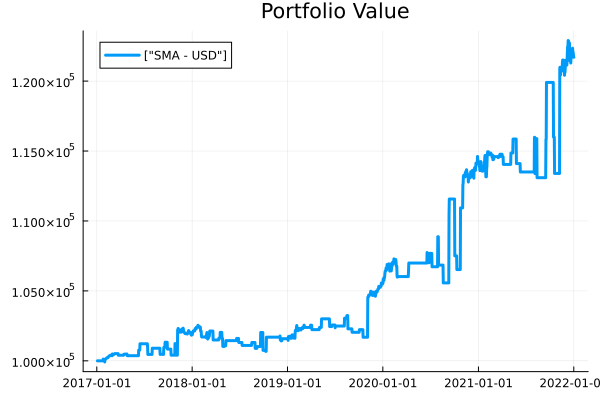

In [6]:
using Plots: plot
plot(results.date, results.dollarValue, title="Portfolio Value", label=["SMA - USD"], linewidth=3)

## Debugging: stockValue when using summarizePerformance



In [1]:
using Pkg; Pkg.add("Suppressor"); using Suppressor: @suppress;
@suppress Pkg.add(url="https://github.com/JuDO-dev/AirBorne.jl#dev")
@suppress Pkg.add(["Dates","Plots","DataFrames"])

using AirBorne.ETL.YFinance: get_interday_data
using Dates: DateTime,datetime2unix
# To generate this data use:
unix(x) = string(round(Int, datetime2unix(DateTime(x))))
data = get_interday_data(["AAPL","GOOG"], unix("2017-01-01"), unix("2022-01-01"))
first(data,4) # Display first 4 rows

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed Suppressor ─ v0.2.4
    Updating `~/.julia/environments/v1.8/Project.toml`
  [fd094767] + Suppressor v0.2.4
    Updating `~/.julia/environments/v1.8/Manifest.toml`
  [fd094767] + Suppressor v0.2.4
Precompiling project...
  ✓ Suppressor
  1 dependency successfully precompiled in 5 seconds. 216 already precompiled.


Row,close,high,low,open,volume,date,unix,exchangeName,timezone,currency,symbol,assetID
,Float64,Float64,Float64,Float64,Int64,DateTime,Int64,String,String,String,String,String
1,29.0375,29.0825,28.69,28.95,115127600,2017-01-03T10:30:00,1483453800,NMS,America/New_York,USD,AAPL,NMS/AAPL
2,29.005,29.1275,28.9375,28.9625,84472400,2017-01-04T10:30:00,1483540200,NMS,America/New_York,USD,AAPL,NMS/AAPL
3,29.1525,29.215,28.9525,28.98,88774400,2017-01-05T10:30:00,1483626600,NMS,America/New_York,USD,AAPL,NMS/AAPL
4,29.4775,29.54,29.1175,29.195,127007600,2017-01-06T10:30:00,1483713000,NMS,America/New_York,USD,AAPL,NMS/AAPL


In [3]:
using AirBorne.Engines.DEDS: run
using AirBorne.Markets.StaticMarket: execute_orders!, expose_data
using AirBorne.Strategies.SMA: interday_initialize!, interday_trading_logic!
using AirBorne.Structures: summarizePerformance
using Dates: DateTime


sma_initialize!(context) = interday_initialize!(context; longHorizon=20, shortHorizon=5)
sma_trading_logic! = interday_trading_logic!

# Run Simulation
# max_iter = 100
@time SMA_context = run(
    data,
    sma_initialize!,
    sma_trading_logic!,
    execute_orders!,
    expose_data;
    audit=true,
    max_date=DateTime(2022, 1, 1),
    verbose=true,
)
SMA_results = summarizePerformance(data, SMA_context)
println("Done")

  8.062442 seconds (2.64 M allocations: 821.047 MiB, 3.30% gc time, 2.06% compilation time: 100% of which was recompilation)
Done


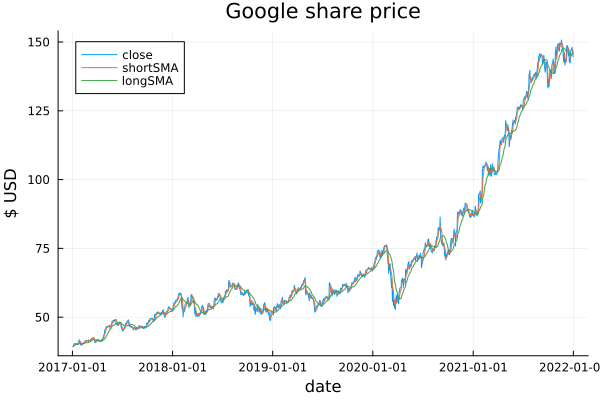

In [4]:
using Plots: scatter!, scatter, plot, plot!
using AirBorne.Utils: movingAverage
goog_data = data[data[!,"symbol"].=="GOOG",:]
short = movingAverage(goog_data.close;windowSize=5)
long = movingAverage(goog_data.close;windowSize=20)
plot(goog_data.date, [goog_data.close, short, long], title="Google share price", label=["close" "shortSMA" "longSMA"], linewidth=1, xlabel="date",ylabel="\$ USD")

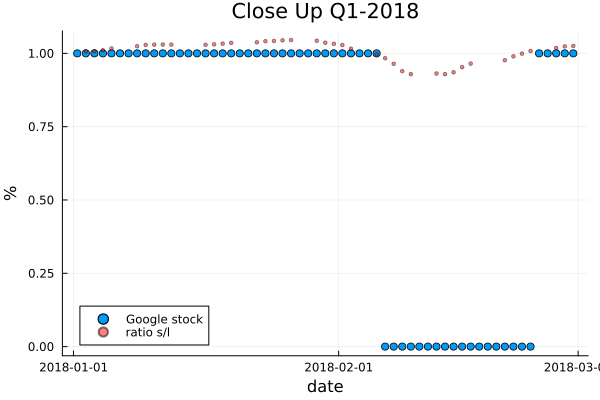

In [7]:
ratio = short./long
cd_d =  (goog_data.date.>=DateTime("2018-01-01") .&& goog_data.date.<DateTime("2018-03-01"))
rd = SMA_results.date
gp = [get(x.portfolio,"NMS/GOOG",0) for x=eachrow(SMA_results)]./100
cd = rd.>=DateTime("2018-01-01") .&& rd.<DateTime("2018-03-01")
scatter(rd[cd], gp[cd], title="Close Up Q1-2018", label="Google stock", xlabel="date",ylabel="%")
scatter!(goog_data.date[cd_d], ratio[cd_d], label="ratio s/l", mc=:red, ms=2, ma=0.5)


 51.628509 seconds (25.98 M allocations: 2.052 GiB, 4.31% gc time, 36.15% compilation time: 10% of which was recompilation)


[ Info: done


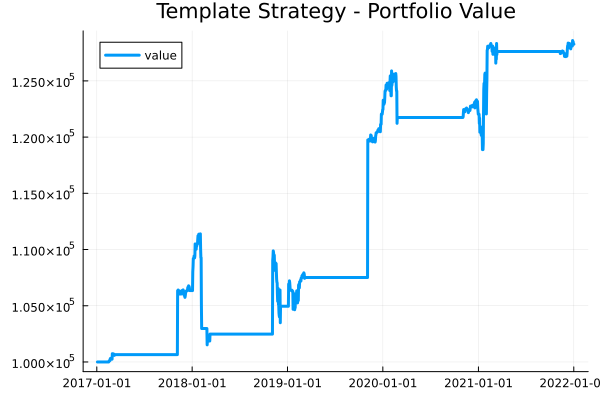

In [8]:
using AirBorne.Engines.DEDS: run
using AirBorne.Markets.StaticMarket: execute_orders!, expose_data
using AirBorne.Strategies.Markowitz: initialize!, trading_logic!
using Dates: DateTime, Day
using AirBorne.Structures: summarizePerformance
using Plots: plot

my_expose_data(context,data) = expose_data(context,data; historical=false)
@time mk_context = run(
    data,
    initialize!,
    trading_logic!,
    execute_orders!,
    my_expose_data;
    audit=true,
    max_date=DateTime(2022, 1, 1),
    verbose=true,
)
@info "done"
mk_results = summarizePerformance(data, mk_context)
plot(mk_results.date, mk_results.dollarValue, title="Template Strategy - Portfolio Value", label="value", linewidth=3)


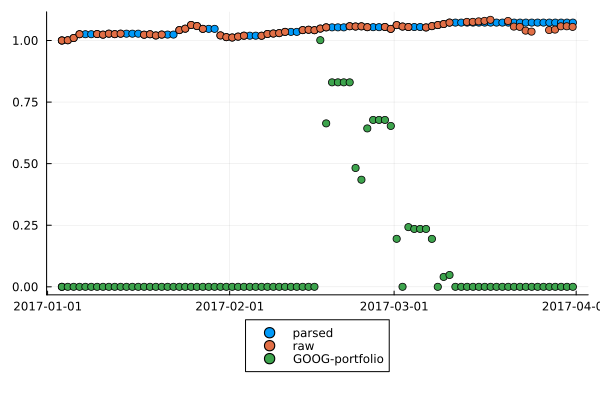

In [30]:

goog_data = data[data[!,"symbol"].=="GOOG",:]

mk_goog = [get(x,"NMS/GOOG",nothing) for x in mk_results.stockValue]
mk_goog_portf = [get(x,"NMS/GOOG",0) for x in mk_results.portfolio]
mk_dates = mk_results.date
r_dates = goog_data.date
r_goog = goog_data.close
goog0 = r_goog[1]

d1= DateTime("2017-01-01")
d2= d1 + Day(90)
mk_ix= mk_dates.>=d1 .&& mk_dates.<=d2
r_ix= r_dates.>=d1 .&& r_dates.<=d2

scatter(mk_dates[mk_ix],mk_goog[mk_ix]./goog0, label="parsed",legend=:outerbottom)
scatter!(r_dates[r_ix],r_goog[r_ix]./goog0, label="raw")
scatter!(mk_dates[mk_ix],mk_goog_portf[mk_ix]./300, label="GOOG-portfolio")
# end

In [32]:
@info mk_dates[mk_ix]

[ Info: [DateTime("2017-01-03T10:30:00"), DateTime("2017-01-03T10:30:00"), DateTime("2017-01-04T10:30:00"), DateTime("2017-01-05T10:30:00"), DateTime("2017-01-06T10:30:00"), DateTime("2017-01-07T10:30:00"), DateTime("2017-01-08T10:30:00"), DateTime("2017-01-09T10:30:00"), DateTime("2017-01-10T10:30:00"), DateTime("2017-01-11T10:30:00"), DateTime("2017-01-12T10:30:00"), DateTime("2017-01-13T10:30:00"), DateTime("2017-01-14T10:30:00"), DateTime("2017-01-15T10:30:00"), DateTime("2017-01-16T10:30:00"), DateTime("2017-01-17T10:30:00"), DateTime("2017-01-18T10:30:00"), DateTime("2017-01-19T10:30:00"), DateTime("2017-01-20T10:30:00"), DateTime("2017-01-21T10:30:00"), DateTime("2017-01-22T10:30:00"), DateTime("2017-01-23T10:30:00"), DateTime("2017-01-24T10:30:00"), DateTime("2017-01-25T10:30:00"), DateTime("2017-01-26T10:30:00"), DateTime("2017-01-27T10:30:00"), DateTime("2017-01-28T10:30:00"), DateTime("2017-01-29T10:30:00"), DateTime("2017-01-30T10:30:00"), DateTime("2017-01-31T10:30:00"), D

In [40]:
eventTimes = sort(unique(data.date);rev=true)
@info pop!(eventTimes)
@info pop!(eventTimes)
pop!([])


[ Info: 2017-01-03T10:30:00
[ Info: 2017-01-04T10:30:00


LoadError: ArgumentError: array must be non-empty